In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from data_parsing import load_trajectories
from functools import partial, reduce

In [30]:
trajectories = load_trajectories('data/MITxPRO+LASERxB1+1T2019/LaaL')
id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
#id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
trajectories.iloc[0]

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 2,
 5,
 12,
 20,
 22,
 24,
 21,
 20,
 18,
 24,
 22,
 20,
 28,
 20,
 1,
 49,
 53,
 54,
 55,
 56,
 58,
 59,
 41,
 44,
 45,
 58,
 41,
 59,
 58,
 59,
 57,
 63,
 64,
 61,
 63,
 64,
 60,
 41,
 67,
 71,
 72,
 73,
 67,
 75,
 77,
 78,
 79,
 80,
 81,
 74,
 82,
 75,
 74,
 75,
 82,
 85,
 86,
 90,
 84,
 88,
 90,
 91,
 67,
 94,
 95,
 96,
 97,
 98,
 99,
 91,
 103,
 101,
 91,
 102,
 101,
 103,
 104,
 105,
 106,
 107,
 109,
 100,
 109,
 111,
 108,
 114,
 112,
 120,
 117,
 114,
 116,
 120,
 112,
 118,
 120,
 121,
 91,
 125,
 126,
 127,
 121,
 129,
 131,
 132,
 133,
 128,
 135,
 134,
 137,
 139,
 121,
 143,
 144,
 145,
 147,
 139,
 143,
 139,
 147,
 149,
 150,
 151,
 146,
 153,
 154,
 155,
 156,
 152,
 158,
 159,
 139,
 160,
 164,
 160,
 165,
 167,
 168,
 165,
 168,
 169,
 172,
 74,
 67,
 75,
 39,
 160,
 164,
 165,
 160,
 167,
 168,
 165,
 39,
 169,
 172,
 173,
 175,
 169,
 177,
 179,
 174,
 181,
 178,
 183,
 182,
 185,
 169,
 186,
 188,
 186,
 190,
 19

In [ ]:
# # complete course structure and module descriptions
# # list of student identifiers and performance statistics, certification, and enrollment data
# # problem UTF-encoding error

# AM_modules = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-modules.txt', sep='\t', encoding='utf-16')

1699

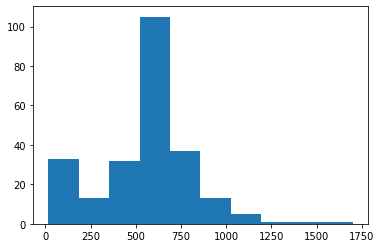

In [3]:
traj_lengths = trajectories.map(len).values
plt.hist(traj_lengths)
max(traj_lengths)

## data generators 

In [23]:
incoming_traj = []
outgoing_traj = []

# this split assumes that we don't need to rebalance for unequal category weights
n_valid = int(2*np.sqrt(len(trajectories)))
n_train = len(trajectories) - n_valid

for traj in trajectories.values:
    incoming_traj.append(np.array(traj[:-1]).reshape(1,-1))
    outgoing_traj.append(np.array(traj[1:]).reshape(-1,1))

index = np.arange(len(trajectories))
np.random.seed(9)
np.random.shuffle(index)

#add data for pass/fail to status
status = np.where(id_and_performance['certGrp']=='Certified (< 70% Grade)', 1, 0)

def data_generator(start, stop, use_status):
     while True:
        for i in range(start, stop):
            x = incoming_traj[index[i]].reshape(1,-1)
            s = np.broadcast_to(status[index[i]], x.shape)
            y = outgoing_traj[index[i]].reshape(1,-1)
            if use_status:
                yield [x,s],y
            else:
                yield x,y

train_generator_simp = partial(data_generator, 0, n_train, False)
valid_generator_simp = partial(data_generator, n_train, n_train+n_valid, False)
train_generator_cond = partial(data_generator, 0, n_train, True)
valid_generator_cond = partial(data_generator, n_train, n_train+n_valid, True)

## Define models

In [15]:
hidden_dim = 30
embedding_dim = 30
# turning trajectories into sets of URLs
number_of_URL = len(reduce(set.union, [set(traj) for traj in trajectories]))
optimizer = Adam(learning_rate=0.0001)

407

In [26]:
input_ = Input(shape=(None,), name='history')
embed = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed)

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(rnn)

model_simp = Model(inputs=input_, outputs=predicted_URL, name='Simple_model')
model_simp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_simp.summary()

Model: "Simple_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
history (InputLayer)         [(None, None)]            0         
_________________________________________________________________
URL_embedding (Embedding)    (None, None, 30)          12210     
_________________________________________________________________
LSTM (LSTM)                  (None, None, 30)          7320      
_________________________________________________________________
Predicted_URL (Dense)        (None, None, 407)         12617     
Total params: 32,147
Trainable params: 32,147
Non-trainable params: 0
_________________________________________________________________


In [27]:
input_x = Input(shape=(None,), name='history')
input_s = Input(shape=(None,), name='status')
embed_x = Embedding(number_of_URL, embedding_dim, name='URL_embedding')(input_x)
embed_s = Embedding(2, hidden_dim, embeddings_initializer='ones', name='Status_embedding')(input_s)

rnn = LSTM(hidden_dim, return_sequences=True, name='LSTM')(embed_x)
masked = Multiply()([rnn, embed_s])

predicted_URL = Dense(number_of_URL, activation = 'softmax', name='Predicted_URL')(masked)

model_cond = Model(inputs=[input_x, input_s], outputs=predicted_URL, name='Conditional_model')
model_cond.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
model_cond.summary()

Model: "Conditional_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
history (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
URL_embedding (Embedding)       (None, None, 30)     12210       history[0][0]                    
__________________________________________________________________________________________________
status (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, None, 30)     7320        URL_embedding[0][0]              
__________________________________________________________________________________

## Run models

In [ ]:
#model_simp.load_weights('weights_simp.h5')
#model_cond.load_weights('weights_cond.h5')

In [28]:
filepath="cond_hiddim30_Lrate_0001_w-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model_cond.fit_generator(train_generator_cond(), 
                    validation_data=valid_generator_cond(),
                    #callbacks=callbacks_list,
                    steps_per_epoch = n_train, #batch size is inherently 1 via generator
                    validation_steps= n_valid,
                    epochs=500,
                    verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 210 steps, validate for 31 steps
Epoch 1/500
  1/210 [..............................] - ETA: 12:07

InvalidArgumentError:  indices[0,447] = 454 is not in [0, 407)
	 [[node Conditional_model/URL_embedding/embedding_lookup (defined at <ipython-input-28-46b40735f5d1>:10) ]] [Op:__inference_distributed_function_9350]

Errors may have originated from an input operation.
Input Source operations connected to node Conditional_model/URL_embedding/embedding_lookup:
 Conditional_model/URL_embedding/embedding_lookup/8097 (defined at /Users/rsciagli/opt/anaconda3/envs/dataweekends/lib/python3.7/contextlib.py:112)

Function call stack:
distributed_function


In [ ]:
# # user list key - session level
# AM_userList = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-userList-key-sessionLevel.csv')
# AM_userList

# # learning pathway network edge lists - edge list for each student in the course that represent a directed 
# # transitions networks  of students pathway through the courses content modules.  this is all students.
# AM_edgelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-edges-cohort.csv')
# AM_edgelist[:5]

In [ ]:
incoming_traj[0].shape

In [ ]:
model.predict([0,1,3,4,5,6])[0,-1].tolist()

In [ ]:
x = np.array([0,1,2,3,4,5,6]).reshape(1,-1)
s = np.zeros(x.shape)
model2.predict([x,s])[0,-1].tolist()

In [ ]:
proposed_traj = [0]
while len(proposed_traj) < 1000 and (len(proposed_traj) == 1 or proposed_traj[-1] != 0):
    x = np.array(proposed_traj).reshape(1,-1)
    #run with s = np.ones(x.shpae) for successful
    s = np.ones(x.shape)
    predicted = np.argmax(model2.predict([x,s])[0,-1])
    #predicted = np.argmax(model.predict(x)[0,-1])
    #print(predicted)
    proposed_traj.append(predicted)
print(proposed_traj)

cert_traj = pd.DataFrame(proposed_traj)
cert_traj.to_csv('AM_cert_traj_lr0001_hid_dim30.csv', header = ['certificate trajectory'], index = False)

In [ ]:
# node list of all students' learning pathway networks
AM_nodelist = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-cohort.csv')
AM_nodelist

In [ ]:
# appendix to the node list that provides a set of XY coordinates to generate a common layout for all networks 
# produced in the analysis.  force atlas with parameterization <- what is this?
AM_node_coord = pd.read_csv('edx-learnerpathway-modeling/data/MITxPRO+AMxB+1T2018/MITxPRO+AMxB+1T2018-stdAgg-nodes-coordinates-FA2.csv')
AM_node_coord[:5]

In [ ]:
# student identifiers and performance statistics, certification, and enrollment data
AM_id_and_performance = pd.read_csv('data/MITxPRO+AMxB+1T2018/MITxPRO-AMxB-1T2018-auth_user-students.csv')
AM_id_and_performance['certGrp'].unique()

In [ ]:
# meta data includes the course title, run dates
LaaL_meta = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-meta.csv')
LaaL_meta

In [ ]:
# complete course structure and module descriptions
# list of student identifiers and performance statistics, certification, and enrollment data

# LaaL_edgelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-modules.csv')
# LaaL_edgelist

In [ ]:
LaaL_edelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-edges.csv')
LaaL_edelist[:5]

In [ ]:
LaaL_nodelist = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes.csv')
LaaL_nodelist[:5]

In [ ]:
LaaL_node_coord = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO+LASERxB1+1T2019-stdAgg-nodes-coordinates-FA2.csv')
LaaL_node_coord[:5]

In [ ]:
LaaL_id_and_performance = pd.read_csv('data/MITxPRO+LASERxB1+1T2019/MITxPRO-LASERxB1-1T2019-auth_user-students.csv')
LaaL_id_and_performance[:5]